In [20]:
#################### Params ###############
import sys
import os
NOVA_HOME = "/home/projects/hornsteinlab/Collaboration/NOVA"
NOVA_DATA_HOME = '/home/projects/hornsteinlab/Collaboration/NOVA/input'
sys.path.insert(1, NOVA_HOME)
print(f"NOVA_HOME: {NOVA_HOME}")
AAT_NOVA_DATA_DIR = "/home/projects/hornsteinlab/Collaboration/Guy_Lior/fuNOVA_Pilot"
RAW_DATASET_NAME = "zstack_collapse_2nd_imaging_sorted"
PROC_DATASET_NAME = "AAT-NOVA_pilot"

preprocessing_path = os.path.join(NOVA_HOME, 'outputs', 'preprocessing', PROC_DATASET_NAME, "brenner")
csv_name = 'raw_metrics_2025-08-25.csv'

mappings_filepath = "/home/projects/hornsteinlab/giliwo/NOVA/manuscript/markers_focus_boundries/markers_focus_boundries_AAT_NOVA.csv"

imgs_path = os.path.join(AAT_NOVA_DATA_DIR, RAW_DATASET_NAME)
           
metric_name = 'Target_Sharpness_Brenner'
img_shape = 1024
percentiles_resolution = 0.0001
percentile_ranges_for_reports = [0, 0.1, 0.2, 0.3, 0.5, 0.7, 1, 2, 5, 10, 15, 20, 30, 40, 60, 75, 80, 85, 90, 95, 98, 99, 99.5, 99.7, 99.8,99.9,100]

NOVA_HOME: /home/projects/hornsteinlab/Collaboration/NOVA


In [21]:
import os
import sys
import concurrent.futures
import numpy as np
import pandas as pd
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from datetime import datetime
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.gridspec import GridSpec

os.environ['NOVA_HOME'] = NOVA_HOME
sys.path.insert(1, os.getenv("NOVA_HOME"))
print(f"NOVA_HOME: {os.getenv('NOVA_HOME')}")

os.environ['NOVA_DATA_HOME'] = NOVA_DATA_HOME
print(f"NOVA_DATA_HOME: {os.getenv('NOVA_DATA_HOME')}")

CREATE_REPORT = False

from src.preprocessing.preprocessing_utils import get_image_focus_quality 
from src.preprocessing.preprocessing_utils import rescale_intensity, fit_image_shape

%reload_ext autoreload
%autoreload 2
%aimport

%matplotlib inline

NOVA_HOME: /home/projects/hornsteinlab/Collaboration/NOVA
NOVA_DATA_HOME: /home/projects/hornsteinlab/Collaboration/NOVA/input
Modules to reload:
all-except-skipped

Modules to skip:



# Utils

In [22]:
def get_metrics(tile, as_string=False):
    sharpness_brenner = get_image_focus_quality(tile)    
    if as_string:
        return f"Brenner: {round(sharpness_brenner, 3)}"
    return sharpness_brenner

def show_images(df, max_samples = 10, lower_bound = 0.5, upper_bound = 99.5):
    for ind, path in enumerate(df.Path.values):
        print(ind)
        if max_samples is not None and ind >= max_samples:
            print(f"Stopping at {ind}. There are {len(df.Path.values)} images in total")
            break
        
        # Target
        target_path = os.path.join(imgs_path, path)
        target_path=target_path.replace("MOmaps","NOVA")
        show_processed_tif(target_path, lower_bound, upper_bound)
        # His DAPI
        # path_l = target_path.split("/")
        # path_l[-2] = 'DAPI'
        
        # file_name = path_l[-1].split("_")
        # dapi_file_name = "_".join([file_name[0], 'w1confDAPI', file_name[-1]])
        # dapi_file_name = "/".join([*path_l[:-1], dapi_file_name])
        # print(dapi_file_name)

        # show_processed_tif(dapi_file_name)
        print('--------------------------------')
        
def init_mappings(markers=[], filepath=None):
    if filepath is not None:     
        if os.path.exists(filepath):
            mappings = pd.read_csv(filepath, index_col=0)
            return mappings
        
    mappings = pd.DataFrame(columns=['Lower_bound', 'Upper_bound'], index=markers)

    return mappings
        
def save_to_mapping(filepath, mappings, marker, value, is_upper_bound):
    col = 'Upper_bound' if is_upper_bound else 'Lower_bound' 
    mappings.loc[marker, col] = value
    
    mappings.to_csv(filepath)
    print(f"File saved to {filepath}")

def show_label(path):
    path_l = path.split("/")
    return path_l[-7:]

def process_tif(path, lower_bound, upper_bound):
    """
    Read and process the image.

    Parameters:
        path (str): Path to the image file.

    Returns:
        ndarray: Processed image.
    """
    # read the image stack
    img = cv2.imread(path, cv2.IMREAD_ANYDEPTH)
    img = fit_image_shape(img, (img_shape, img_shape))
    # rescale pixel intensities
    img = rescale_intensity(img, lower_bound=lower_bound, upper_bound=upper_bound)
    return img
    
def show_processed_tif(path, lower_bound, upper_bound):
    img = process_tif(path, lower_bound, upper_bound)
    print(get_metrics(img, True))
    # show the image with grid 
    fig, ax = plt.subplots(figsize=(7,7))
    plt.imshow(img, cmap='gray')
    put_tiles_grid(image=img, ax=ax)
    plt.axis('off')
    plt.title(show_label(path), color='purple')
    print(f"Img shape: {img.shape}")
    plt.show()

def put_tiles_grid(image, ax):
    # assumes 1000x1000 image
    import matplotlib.patches as patches

    # Add dashed grid lines for 64 blocks
    num_blocks = 10
    block_size = 100

    for i in range(1, num_blocks):
        # Draw horizontal dashed lines
        ax.plot([0, 1000], [i * block_size, i * block_size], linestyle='--', lw=1, alpha=0.5, color='pink')

        # Draw vertical dashed lines
        ax.plot([i * block_size, i * block_size], [0, 1000], linestyle='--', lw=1, alpha=0.5, color='pink')

    # Remove x and y axis labels
    ax.set_xticks([])
    ax.set_yticks([])

    # Add a title
    plt.title('Image with Dashed Grid of 64 Blocks')

def update_all_mappings(mappings, thresholds, df):
    # Iterate over the rows and fill the thresholds
    for marker in mappings.index:
        if marker in thresholds and thresholds[marker] is not None:
            df_marker = df.loc[df['Marker'] == marker]
            percentiles = df_marker[metric_name].describe(percentiles=percentiles_to_describe)
            mappings.loc[marker, "Lower_bound"] = round(percentiles[f'{thresholds[marker][0]}%'], 2)
            mappings.loc[marker, "Upper_bound"] = round(percentiles[f'{thresholds[marker][1]}%'], 2)
    return mappings

def create_histogram_report_by_batch(df: pd.DataFrame, all_markers: list) -> None:
    """
    Generate a PDF report with histograms for each marker.

    Parameters:
        df (pd.DataFrame): DataFrame containing the images data.
        all_markers (list): List of unique markers.

    Returns:
        None
    """    
    with PdfPages('Marker_histogram_by_batch.pdf') as pdf:
        for marker in all_markers:
            print(marker)
            df_marker = df.loc[df['Marker'] == marker]
            percentiles = df_marker[metric_name].describe(percentiles=percentiles_to_describe)
            create_histogram(
                df_marker, percentiles, 
                low_perc=thresholds[marker][0], 
                high_perc=thresholds[marker][1], 
                overlay_group=['Batch'], 
                x_min=0.1, x_max=99.9
            )
            plt.title(marker)
            pdf.savefig()
            plt.close()
            
def create_histogram(
    df_marker: pd.DataFrame, 
    percentiles: pd.Series, 
    low_perc: float = 0.5, 
    high_perc: float = 99.9, 
    x_min: float = None, 
    x_max: float = None, 
    overlay_group: list = None,
    plot_base: bool = True,
    actual_x_limits: tuple = None
) -> None:
    """
    Create a histogram of the Brenner values of a certain marker.

    Parameters:
        df_marker (pd.DataFrame): Marker's data.
        percentiles (pd.Series): Percentile values for annotations.
        low_perc (float): Low percentile threshold for annotations.
        high_perc (float): High percentile threshold for annotations.
        x_min (float, optional): Minimum x-axis value for the histogram.
        x_max (float, optional): Maximum x-axis value for the histogram.
        overlay_group (list, optional): Columns to group and overlay histograms.
        plot_base (bool): Whether to plot the base histogram.
        actual_x_limits (tuple, optional): Tuple specifying actual x_min and x_max values.

    Returns:
        None
    """
    assert low_perc < high_perc, "'low_perc' must be less than 'high_perc'"
    
    # Determine histogram range
    if actual_x_limits:
        hist_range = actual_x_limits  # Use passed x_min and x_max
    else:
        hist_range = (percentiles[f'{x_min}%'], percentiles[f'{x_max}%']) if x_min is not None and x_max is not None else None
    
    # Plot base histogram
    if plot_base:
        plt.hist(df_marker[metric_name].values, bins=100, range=hist_range, color=plt.cm.tab10(range(1))[0], 
                 alpha=0.3, label='Brenner scores')
    
    # Plot overlays
    if overlay_group is not None:
        grouped_data = df_marker.groupby(overlay_group)
        unique_groups = grouped_data.groups.keys()
        colors = plt.cm.tab10(range(len(unique_groups)))

        for color, group in zip(colors, unique_groups):
            group_data = grouped_data.get_group(group)
            group_label = ' - '.join(map(str, group)) if isinstance(group, tuple) else group
            plt.hist(group_data[metric_name].values, bins=100, range=hist_range, alpha=0.4, label=group_label, color=color)

    # Add percentile markers
    plt.scatter(percentiles['50%'], 0.5, color='yellow', s=12, label='50th percentile')
    plt.scatter(percentiles[f'{high_perc}%'], 0.5, color='orange', s=12, label=f'{high_perc}th percentile')
    plt.scatter(percentiles[f'{low_perc}%'], 0.5, color='red', s=12, label=f'{low_perc}th percentile')

    # Remove duplicate legend entries
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())

def generate_marker_reports(
    df: pd.DataFrame, 
    all_markers: list, 
    output_folder: str, 
    percentiles_to_describe: list, 
    percentile_ranges: list, 
    max_samples: int
) -> None:
    """
    Generate a detailed report for each marker, including histograms and filtered images.

    Parameters:
        df (pd.DataFrame): DataFrame containing the data.
        all_markers (list): List of unique markers.
        output_folder (str): Path to save the output PDFs.
        percentiles_to_describe (list): List of percentiles to describe the metric.
        percentile_ranges (list): List of percentile ranges for filtering.
        max_samples (int): Maximum number of images to display per range.

    Returns:
        None
    """
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for marker in all_markers:
        print(marker)
        df_marker = df.loc[df['Marker'] == marker]
        percentiles = df_marker[metric_name].describe(percentiles=percentiles_to_describe)

        # Define the actual x-axis limits for consistent base and overlay histograms
        actual_x_limits = (percentiles['0%'], percentiles['97%'])

        pdf_path = os.path.join(output_folder, f'output_report_{marker}.pdf')
        with PdfPages(pdf_path) as pdf:
            # Generate histograms with overlays for different groups
            groups = ['Condition', 'Batch', 'Rep', 'CellLine']
            for group in groups:
                create_histogram(
                    df_marker,
                    percentiles,
                    low_perc=0,
                    high_perc=97,
                    actual_x_limits=actual_x_limits,
                    overlay_group=[group]
                )
                plt.title(f"Histogram with Overlay by {group}")
                pdf.savefig()  # Save current figure to the PDF
                plt.close()

            # Combined base histogram and overlay for each cell line
            for CL in np.unique(df_marker['CellLine']):
                create_histogram(
                    df_marker,
                    percentiles,
                    low_perc=0,
                    high_perc=97,
                    actual_x_limits=actual_x_limits,
                )
                
                # Filter and overlay the specific cell line
                df_tmp = df_marker.loc[df_marker['CellLine'] == CL]
                percentiles_tmp = df_tmp[metric_name].describe(percentiles=percentiles_to_describe)
                create_histogram(
                    df_tmp,
                    percentiles,
                    low_perc=0,
                    high_perc=97,
                    actual_x_limits=actual_x_limits,
                    overlay_group=['CellLine', 'Condition'], plot_base = False
                )
                plt.title(f"Histogram for (Cell Line: {CL})")
                # Save the combined plot to the PDF
                pdf.savefig()
                plt.close()

            # Remaining parts of the function (filtered images, percentile ranges, etc.)
            for i in range(len(percentile_ranges) - 1):
                per_min = np.round(percentile_ranges[i], 2)
                per_max = np.round(percentile_ranges[i + 1], 2)
                assert per_min < per_max, "Percentile range minimum must be less than the maximum."
                threshold = percentiles[f'{per_min}%']
                threshold_second = percentiles[f'{per_max}%']

                c = (df_marker[metric_name] >= threshold) & (df_marker[metric_name] <= threshold_second)
                df_marker_filtered = df_marker[c].sample(frac=1, random_state=1)

                text_output = (f'Images between %{per_min} - {per_max}%\n'
                               f"Number of {marker} images in threshold {threshold} "
                               f"({per_min}%) and {threshold_second} ({per_max}%): "
                               f"{len(df_marker_filtered)}\n\n"
                               f"{df_marker_filtered['CellLine'].value_counts().to_string()}\n\n"
                               f"{df_marker_filtered['Condition'].value_counts().to_string()}\n\n")

                fig = plt.figure(figsize=(12, 8))
                gs = GridSpec(3, 1, figure=fig, height_ratios=[1, 2, 0.1])
                text_ax = fig.add_subplot(gs[0, :])
                text_ax.axis('off')
                text_ax.text(0.01, 0.99, text_output, ha='left', va='top', fontsize=12, wrap=True)

                filtered_paths = df_marker_filtered['Path'].values
                num_images = min(max_samples, len(filtered_paths))
                img_gs = gs[1].subgridspec(1, num_images, wspace=0.1)

                for ind, path in enumerate(filtered_paths[:num_images]):
                    target_path = os.path.join(output_folder, path)
                    img = process_tif(target_path)

                    ax = fig.add_subplot(img_gs[0, ind])
                    ax.imshow(img, cmap='gray')
                    put_tiles_grid(image=img, ax=ax)
                    ax.axis('off')

                    labels = show_label(path)
                    perc_brenner = abs(percentiles[[per for per in percentiles.keys() if '%' in per]] - get_image_focus_quality(img)).idxmin()
                    ax.set_title(f"{labels[1]}, {labels[3]}, {get_metrics(img, True)}, {perc_brenner}", color='purple', fontsize=10)

                plt.tight_layout()
                pdf.savefig(fig)
                plt.close(fig)

In [23]:
import pandas as pd
import numpy as np

def calculate_percentile_bounds(df_data: pd.DataFrame, df_bounds: pd.DataFrame) -> pd.DataFrame:
    result = []
    
    for marker, row in df_bounds.iterrows():
        # Subset the data for the current marker
        subset = df_data[df_data["Marker"] == marker]["Target_Sharpness_Brenner"]
        
        if subset.empty:
            lower_pct, upper_pct = np.nan, np.nan
        else:
            lower_pct = (subset < row["Lower_bound"]).mean() * 100
            upper_pct = (subset < row["Upper_bound"]).mean() * 100

        result.append({
            "Marker": marker,
            "Lower_percentile": lower_pct,
            "Upper_percentile": upper_pct
        })
    
    return pd.DataFrame(result).set_index("Marker")

# Main

In [24]:
df = pd.read_csv(os.path.join(preprocessing_path, csv_name))
df

Path  \
0       /home/projects/hornsteinlab/Collaboration/Guy_...   
1       /home/projects/hornsteinlab/Collaboration/Guy_...   
2       /home/projects/hornsteinlab/Collaboration/Guy_...   
3       /home/projects/hornsteinlab/Collaboration/Guy_...   
4       /home/projects/hornsteinlab/Collaboration/Guy_...   
...                                                   ...   
307195  /home/projects/hornsteinlab/Collaboration/Guy_...   
307196  /home/projects/hornsteinlab/Collaboration/Guy_...   
307197  /home/projects/hornsteinlab/Collaboration/Guy_...   
307198  /home/projects/hornsteinlab/Collaboration/Guy_...   
307199  /home/projects/hornsteinlab/Collaboration/Guy_...   

                                               RootFolder      Marker  \
0       /home/projects/hornsteinlab/Collaboration/Guy_...  CathepsinD   
1       /home/projects/hornsteinlab/Collaboration/Guy_...  CathepsinD   
2       /home/projects/hornsteinlab/Collaboration/Guy_...  CathepsinD   
3       /home/projects/hornsteinlab/Collaboration/Guy_...  CathepsinD   
4       /home/projects/hornsteinlab/Collaboration/Guy_...  CathepsinD   
...                                                   ...         ...   
307195  /home/projects/hornsteinlab/Collaboration/Guy_...       SMI32   
307196  /home/projects/hornsteinlab/Collaboration/Guy_...       SMI32   
307197  /home/projects/hornsteinlab/Collaboration/Guy_...       SMI32   
307198  /home/projects/hornsteinlab/Collaboration/Guy_...       SMI32   
307199  /home/projects/hornsteinlab/Collaboration/Guy_...       SMI32   

        Condition CellLine    Batch_Rep   Rep   Batch  \
0            CYLD       C9  batch1/rep1  rep1  batch1   
1            CYLD       C9  batch1/rep1  rep1  batch1   
2            CYLD       C9  batch1/rep1  rep1  batch1   
3            CYLD       C9  batch1/rep1  rep1  batch1   
4            CYLD       C9  batch1/rep1  rep1  batch1   
...           ...      ...          ...   ...     ...   
307195  Untreated      CTL  batch2/rep2  rep2  batch2   
307196  Untreated      CTL  batch2/rep2  rep2  batch2   
307197  Untreated      CTL  batch2/rep2  rep2  batch2   
307198  Untreated      CTL  batch2/rep2  rep2  batch2   
307199  Untreated      CTL  batch2/rep2  rep2  batch2   

        Target_Sharpness_Brenner  
0                    2400.992848  
1                    2152.359954  
2                    2261.068602  
3                    2185.576957  
4                    1697.117103  
...                          ...  
307195                628.289746  
307196               1147.210674  
307197               2338.733230  
307198                171.315427  
307199                467.481667  

[307200 rows x 9 columns]

See existing brenner cutoffs as percentiles of the new data you are currently working on

In [25]:
df['Marker'].value_counts()

Marker
DAPI            76800
CathepsinD      12800
ATF6            12800
FK-2            12800
Cas3            12800
pS6             12800
pAMPK           12800
HDGFL2          12800
pTDP-43         12800
TDP-43          12800
UNC13A          12800
PAR             12800
Calreticulin    12800
pDRP1           12800
pCaMKIIa        12800
TOMM20          12800
p62             12800
LC3-II          12800
SMI32           12800
Name: count, dtype: int64

In [26]:
counts = df['Marker'].value_counts()
all_markers = df['Marker'].unique()
print(len(all_markers))
print(f'all_markers: {all_markers}')



19
all_markers: ['CathepsinD' 'DAPI' 'LC3-II' 'p62' 'TOMM20' 'pCaMKIIa' 'pDRP1'
 'Calreticulin' 'PAR' 'UNC13A' 'ATF6' 'TDP-43' 'pTDP-43' 'HDGFL2' 'pAMPK'
 'pS6' 'Cas3' 'FK-2' 'SMI32']


In [27]:
mappings = init_mappings(markers=all_markers, filepath=mappings_filepath)
mappings

Lower_bound  Upper_bound
DAPI                58.02     19728.34
Cas3               160.58      8327.49
FK-2                67.97     11010.36
SMI32               47.09     64126.56
pDRP1              207.40      4055.00
TOMM20             211.10      5590.68
pCaMKIIa           169.36      3153.38
pTDP-43            114.40      7485.59
TDP-43             117.76      8235.15
ATF6               135.56      5579.29
pAMPK               61.84     10539.62
HDGFL2             148.08      6790.27
pS6                 94.01     37611.53
PAR                112.15      7086.02
UNC13A             132.44      9090.57
Calreticulin       127.38      7975.72
LC3-II             282.30      8405.24
p62                464.49      5674.53
CathepsinD         368.52      4432.74

In [28]:
bounds_dict = mappings.apply(lambda row: (row["Lower_bound"], row["Upper_bound"]), axis=1).to_dict()
bounds_dict

{'DAPI': (58.02, 19728.34),
 'Cas3': (160.58, 8327.49),
 'FK-2': (67.97, 11010.36),
 'SMI32': (47.09, 64126.56),
 'pDRP1': (207.4, 4055.0),
 'TOMM20': (211.1, 5590.68),
 'pCaMKIIa': (169.36, 3153.38),
 'pTDP-43': (114.4, 7485.59),
 'TDP-43': (117.76, 8235.15),
 'ATF6': (135.56, 5579.29),
 'pAMPK': (61.84, 10539.62),
 'HDGFL2': (148.08, 6790.27),
 'pS6': (94.01, 37611.53),
 'PAR': (112.15, 7086.02),
 'UNC13A': (132.44, 9090.57),
 'Calreticulin': (127.38, 7975.72),
 'LC3-II': (282.3, 8405.24),
 'p62': (464.49, 5674.53),
 'CathepsinD': (368.52, 4432.74)}

In [29]:
percentiles_to_describe = np.arange(0, 1+percentiles_resolution, percentiles_resolution)
percentiles_to_describe

array([0.000e+00, 1.000e-04, 2.000e-04, ..., 9.998e-01, 9.999e-01,
       1.000e+00])

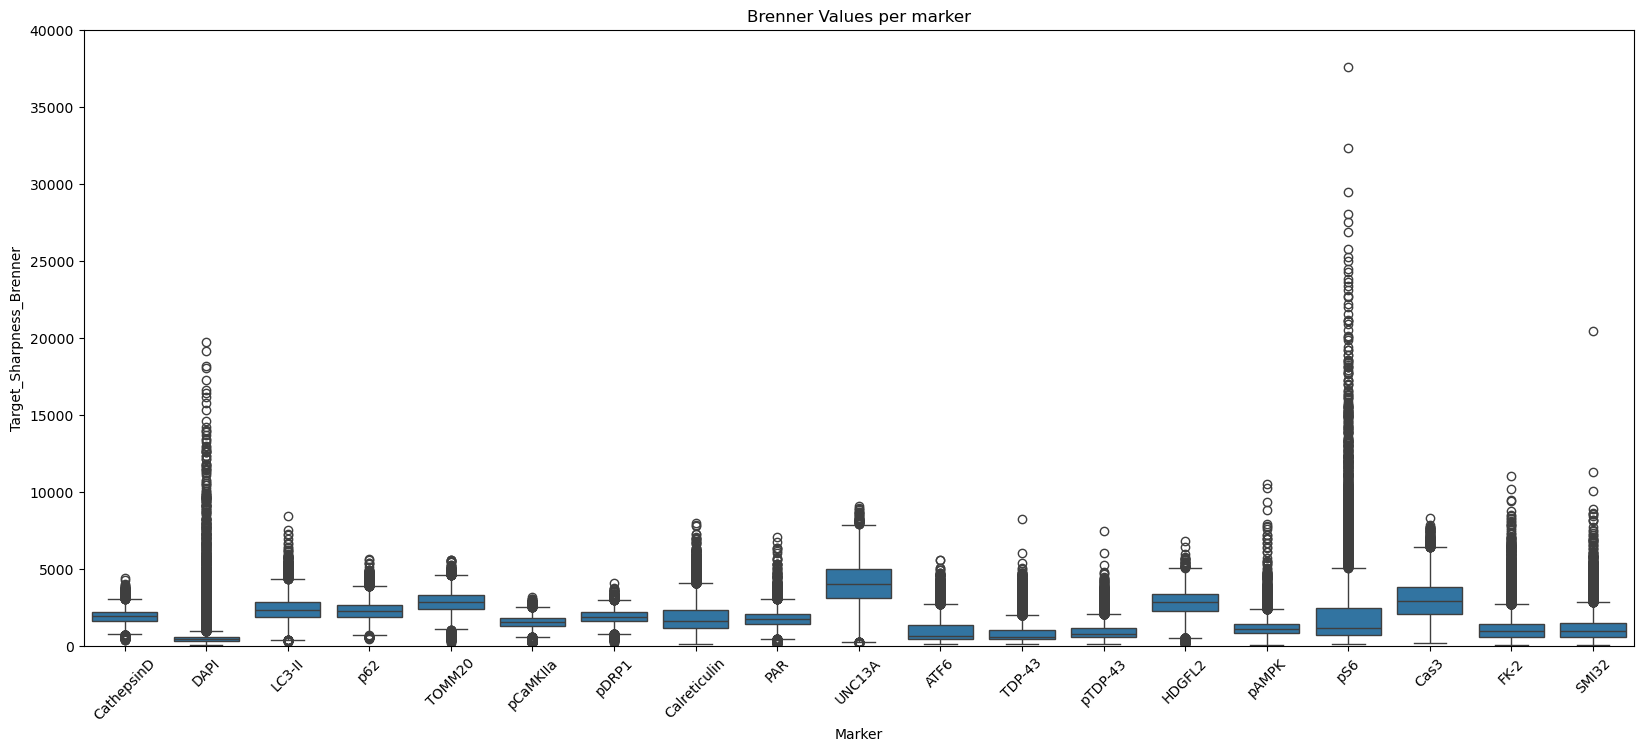

In [30]:
import seaborn as sns

# Plotting
plt.figure(figsize=(20,8))
sns.boxplot(x='Marker', y='Target_Sharpness_Brenner', data=df)
plt.xticks(rotation=45)
plt.title('Brenner Values per marker')
plt.ylim(0, 40000)
plt.show()

In [31]:
stats = df.groupby("Marker")["Target_Sharpness_Brenner"].describe()
stats

count         mean          std         min          25%  \
Marker                                                                     
ATF6          12800.0  1056.135891   881.758488  135.560439   463.905173   
Calreticulin  12800.0  1887.488059  1013.476883  127.383162  1174.692937   
Cas3          12800.0  2969.112207  1276.411029  160.579630  2041.931577   
CathepsinD    12800.0  1908.943899   474.536687  368.524009  1613.738124   
DAPI          76800.0   561.316051   647.580412   58.015502   310.928954   
FK-2          12800.0  1226.411299  1036.560943   67.967085   597.907665   
HDGFL2        12800.0  2724.829604   993.250379  148.083353  2239.705652   
LC3-II        12800.0  2392.638173   859.797869  282.303132  1874.836486   
PAR           12800.0  1777.391670   601.876920  112.151988  1432.175506   
SMI32         12800.0  1203.691697  1109.195704   47.086428   583.304326   
TDP-43        12800.0   948.671915   836.377484  117.759538   431.541948   
TOMM20        12800.0  2863.740824   674.965355  211.097012  2414.431447   
UNC13A        12800.0  4053.723673  1399.351688  132.443885  3112.551155   
p62           12800.0  2302.516738   633.162877  464.491117  1877.407915   
pAMPK         12800.0  1214.898995   632.820018   61.843129   825.250974   
pCaMKIIa      12800.0  1529.345580   407.525522  169.355096  1293.051971   
pDRP1         12800.0  1891.549982   455.551910  207.403284  1616.980292   
pS6           12800.0  2128.518947  2605.060085   94.009315   708.104202   
pTDP-43       12800.0   978.508188   664.793451  114.404570   550.160100   

                      50%          75%           max  
Marker                                                
ATF6           659.185984  1369.914848   5579.290785  
Calreticulin  1629.756693  2326.343266   7975.722929  
Cas3          2909.286146  3797.991562   8327.485815  
CathepsinD    1911.304287  2195.756142   4432.738147  
DAPI           423.174334   584.954810  19728.341947  
FK-2           941.161656  1434.829186  11010.357735  
HDGFL2        2841.368471  3374.543103   6790.270255  
LC3-II        2358.669434  2871.823572   8405.236330  
PAR           1747.814304  2084.251278   7086.017206  
SMI32          936.382932  1487.465862  64126.561295  
TDP-43         607.058728  1055.145894   8235.151837  
TOMM20        2835.556860  3290.886310   5590.680006  
UNC13A        4022.873762  5005.127915   9090.571379  
p62           2265.787515  2674.287901   5674.531621  
pAMPK         1085.186341  1449.696602  10539.617467  
pCaMKIIa      1531.542099  1782.376047   3153.381574  
pDRP1         1882.205064  2170.817327   4054.998857  
pS6           1193.225807  2460.550761  37611.533484  
pTDP-43        749.503523  1153.069349   7485.589947

# Create Brenner reports

Run this block if you want to generate Brenner reports

In [32]:
if CREATE_REPORT:
    output_folder = f"{preprocessing_path}/brenner_reports{PROC_DATASET_NAME}_{datetime.now().strftime('%Y-%m-%d')}"
    print('output_folder is', output_folder)
    generate_marker_reports(df, all_markers, output_folder, percentiles_to_describe, percentile_ranges_for_reports, max_samples=3)

# Examine and set Brenner one by one (Option 1)

In [33]:
marker = 'DAPI'
lower_bound = 0.5
upper_bound = 99.95
# [marker] Options:
# ['CathepsinD', 'DAPI', 'LC3-II', 'p62', 'TOMM20', 'pCaMKIIa',
#        'pDRP1', 'Calreticulin', 'PAR', 'UNC13A', 'ATF6', 'TDP-43',
#        'pTDP-43', 'HDGFL2', 'pAMPK', 'pS6', 'Cas3', 'FK-2', 'SMI32']

Cropping image to fit


marker = DAPI, per: 1% (per_second_bound=40%), max_samples = 20, is upper bound: True
Number of DAPI images in threshold 156.6778979052484 (1%) (and 375.92719857290507 (40%)): 29952



CellLine
CTL    16317
C9     13635
Condition
Intergenic      2248
NDUFS2          2115
NT-6301-3085    2110
NT-1873         2088
RALA            2066
TLK1            2008
MAPKAP1         2000
NRIP1           1966
PPP2R1A         1874
CYLD            1833
RANBP17         1828
PIK3C3          1758
HMGCS1          1717
NDUFAB1         1687
TARDBP          1674
Untreated        980
0
Brenner: 174.373
Img shape: (1024, 1024)


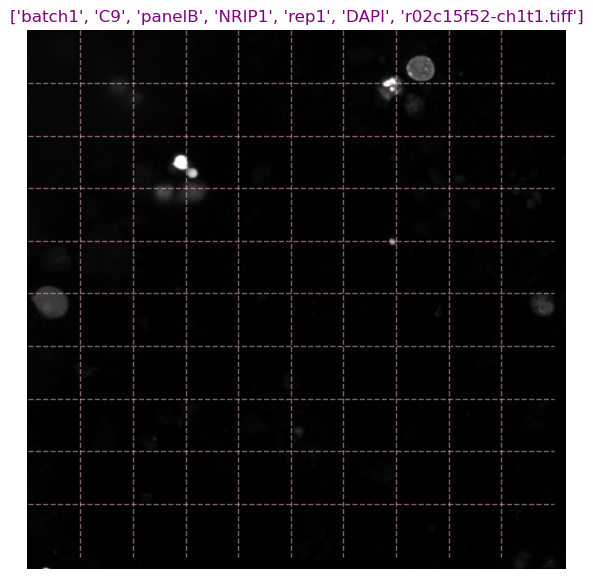

Cropping image to fit


--------------------------------
1
Brenner: 173.964
Img shape: (1024, 1024)


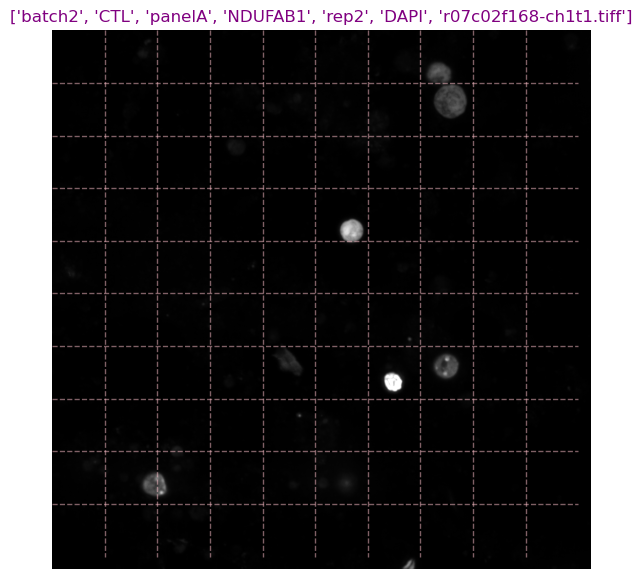

Cropping image to fit


--------------------------------
2
Brenner: 209.994
Img shape: (1024, 1024)


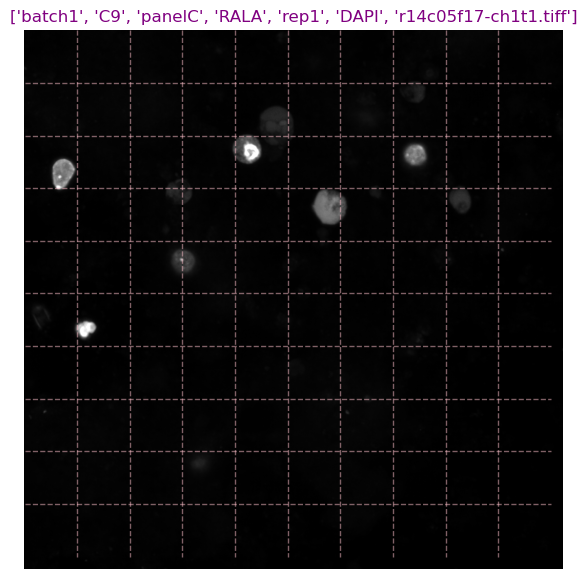

Cropping image to fit


--------------------------------
3
Brenner: 259.63
Img shape: (1024, 1024)


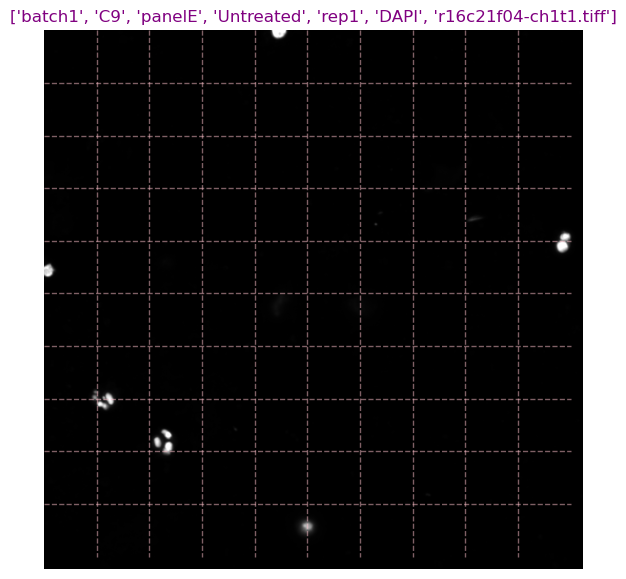

Cropping image to fit


--------------------------------
4
Brenner: 174.744
Img shape: (1024, 1024)


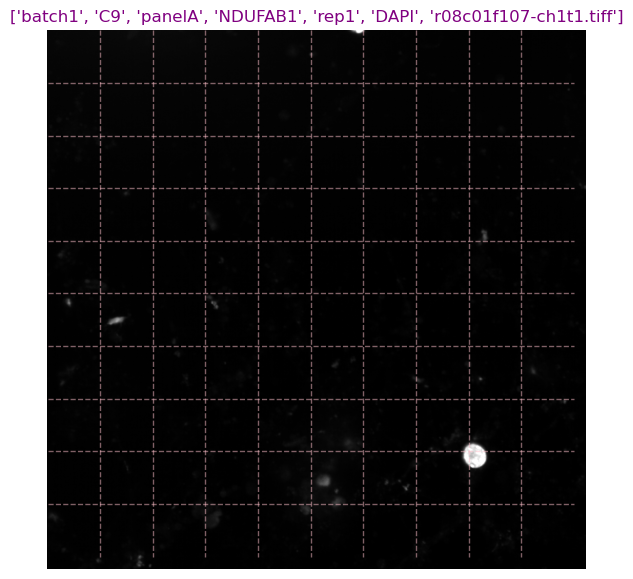

--------------------------------
5


Cropping image to fit


Brenner: 219.742
Img shape: (1024, 1024)


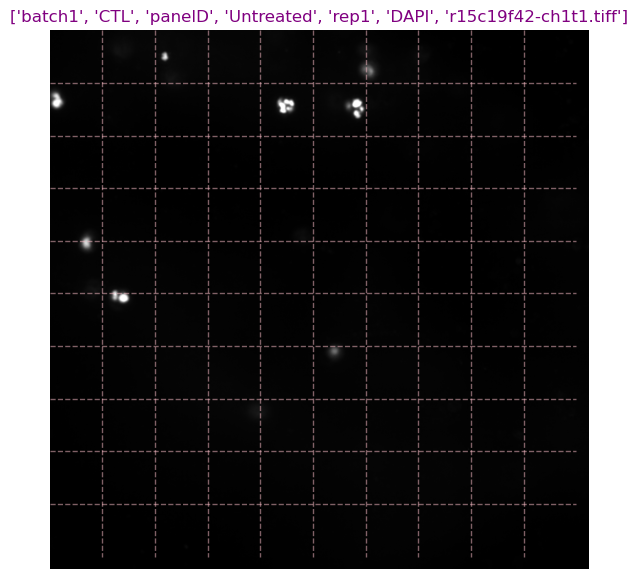

Cropping image to fit


--------------------------------
6
Brenner: 171.625
Img shape: (1024, 1024)


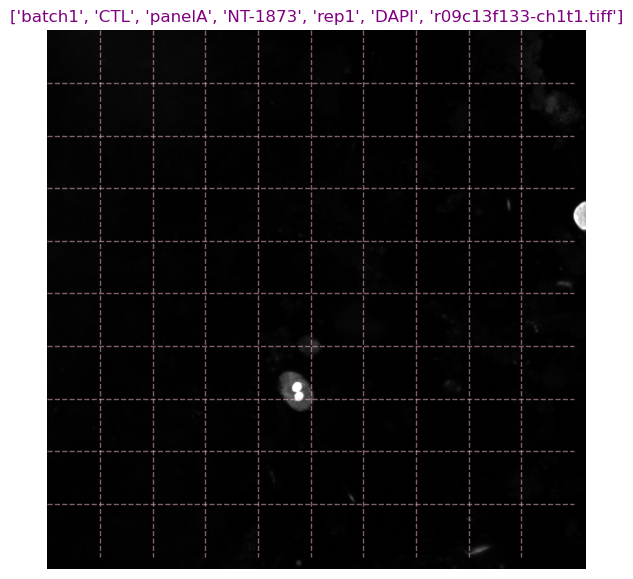

--------------------------------
7


Cropping image to fit


Brenner: 249.555
Img shape: (1024, 1024)


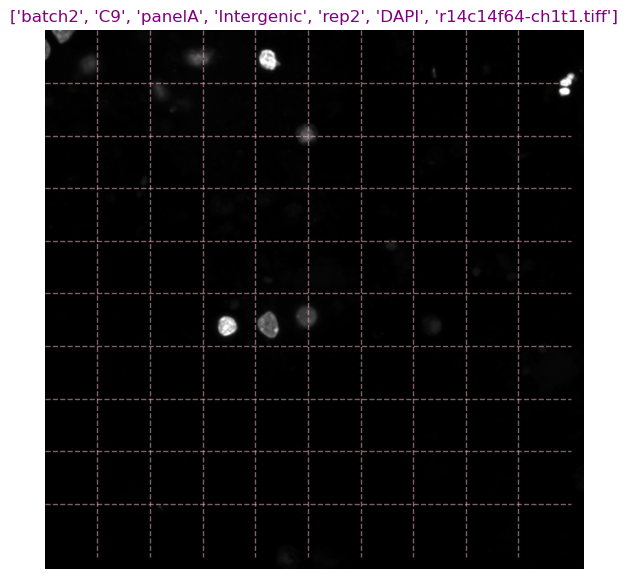

Cropping image to fit


--------------------------------
8
Brenner: 157.635
Img shape: (1024, 1024)


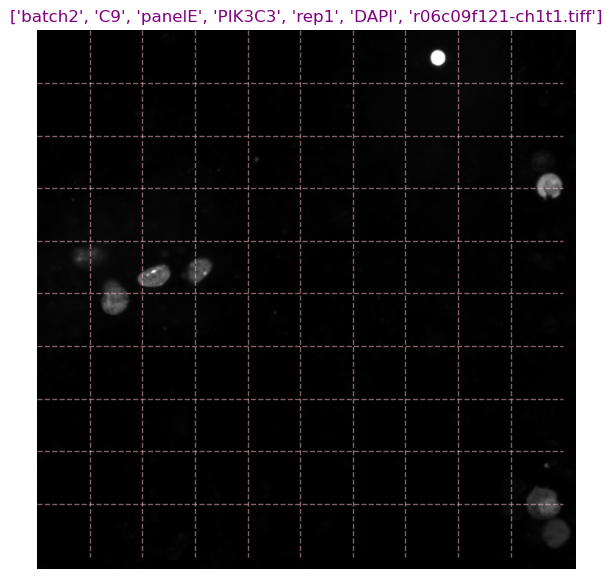

Cropping image to fit


--------------------------------
9
Brenner: 110.534
Img shape: (1024, 1024)


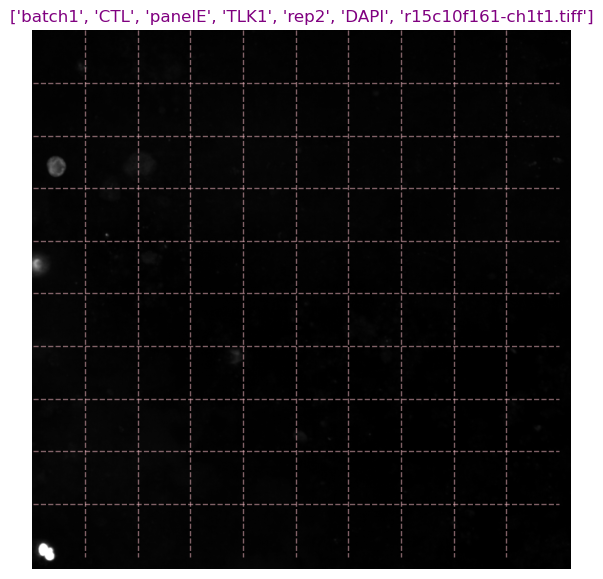

--------------------------------
10


Cropping image to fit


Brenner: 171.472
Img shape: (1024, 1024)


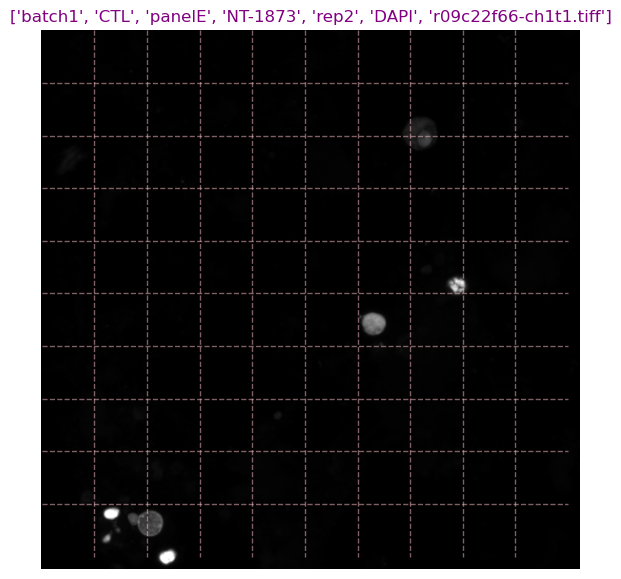

Cropping image to fit


--------------------------------
11
Brenner: 175.862
Img shape: (1024, 1024)


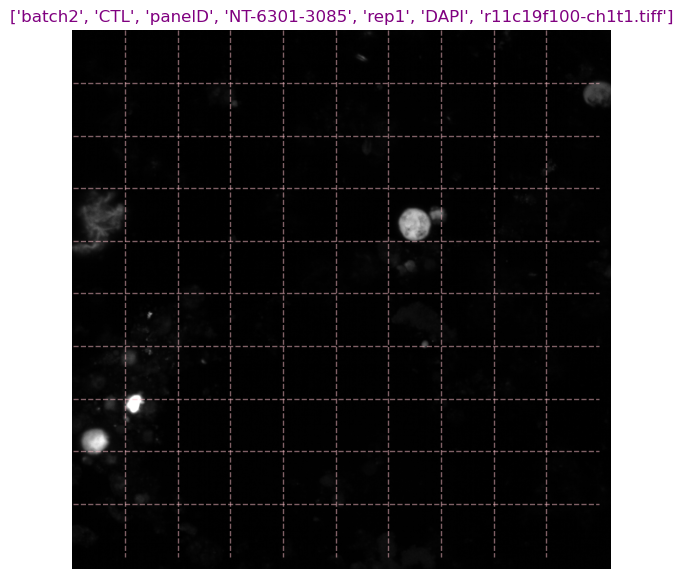

Cropping image to fit


--------------------------------
12
Brenner: 178.456
Img shape: (1024, 1024)


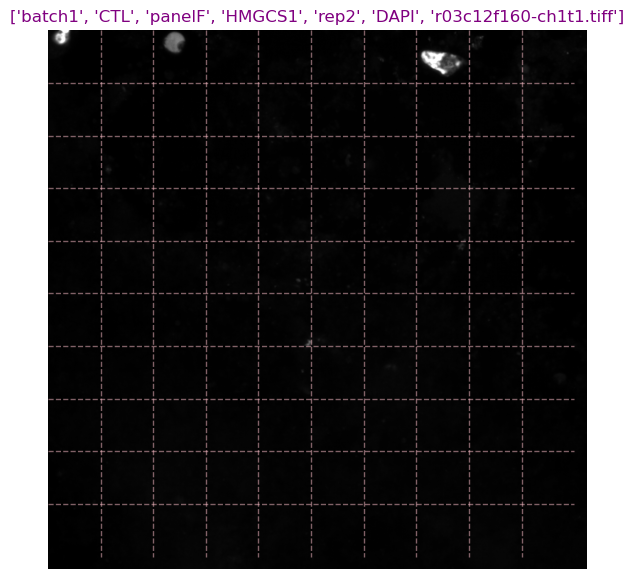

--------------------------------
13


Cropping image to fit


Brenner: 120.401
Img shape: (1024, 1024)


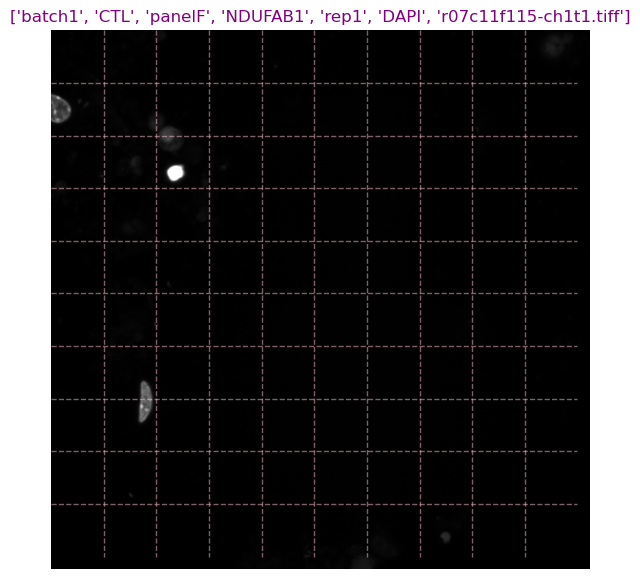

Cropping image to fit


--------------------------------
14
Brenner: 189.009
Img shape: (1024, 1024)


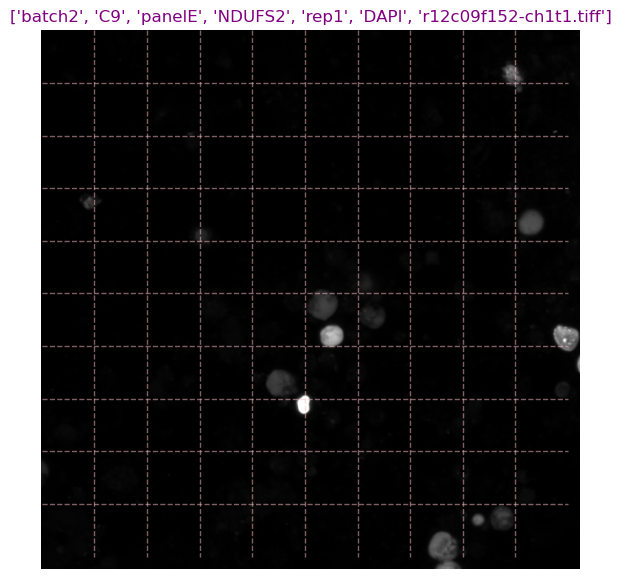

Cropping image to fit


--------------------------------
15


Brenner: 189.117
Img shape: (1024, 1024)


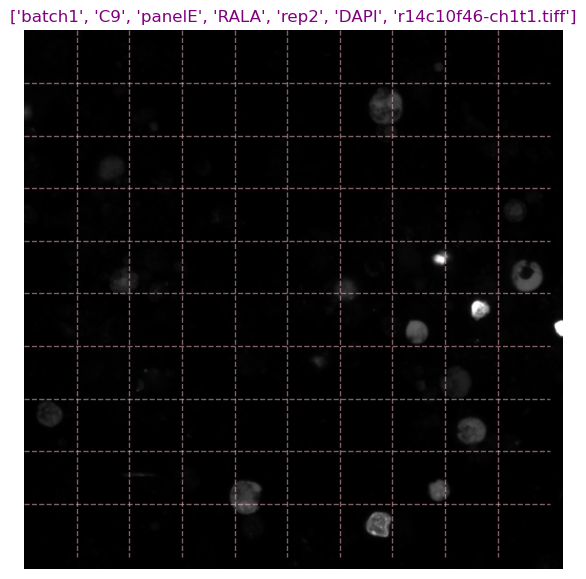

Cropping image to fit


--------------------------------
16
Brenner: 272.329
Img shape: (1024, 1024)


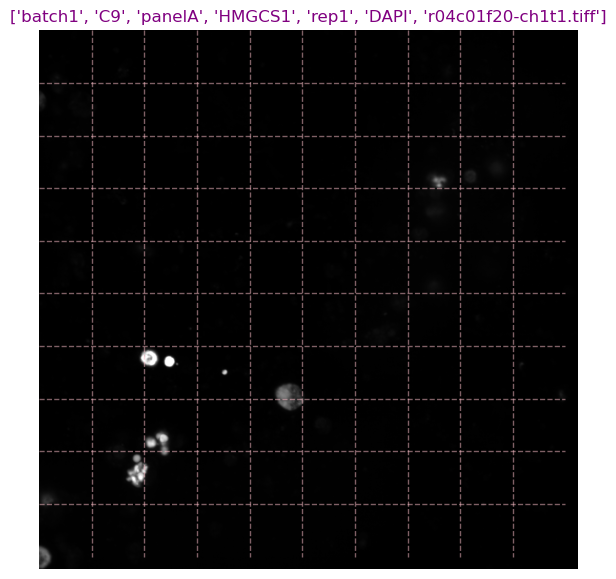

Cropping image to fit


--------------------------------
17
Brenner: 280.768
Img shape: (1024, 1024)


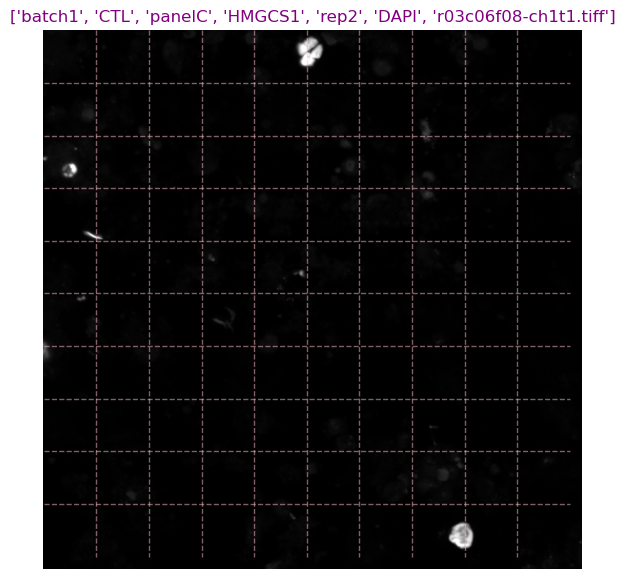

Cropping image to fit


--------------------------------
18
Brenner: 222.132
Img shape: (1024, 1024)


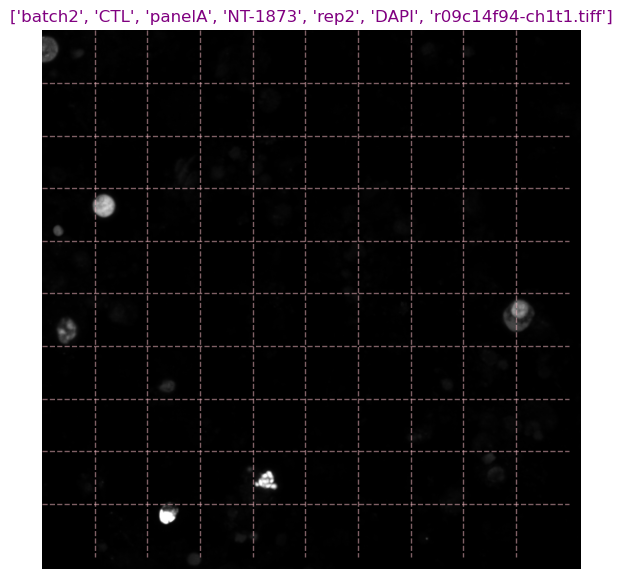

Cropping image to fit


--------------------------------
19
Brenner: 300.13
Img shape: (1024, 1024)


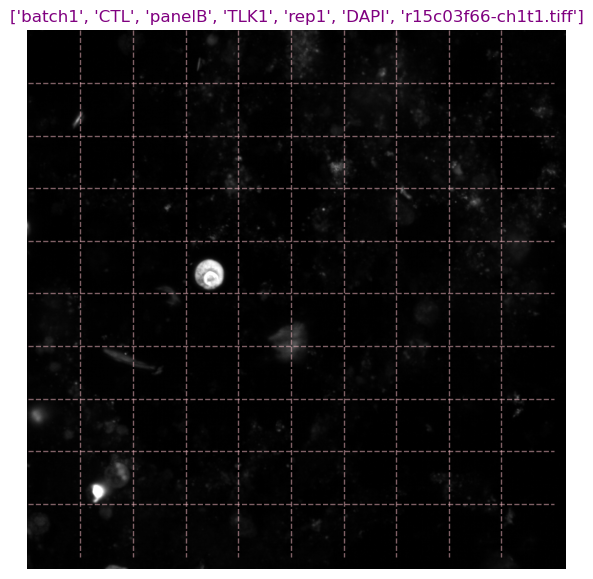

--------------------------------
20
Stopping at 20. There are 29952 images in total


In [34]:
#################### SAFE ZONE TO CHANGE ###############


# [per] Options: 0-100
per = 1 # percentile threshold 

# [per] Options: 0-100
# *Optional! if you want to view images between per and another threshold
per_second_bound = 40

max_samples = 20 # set max number of images (in threshold) to show

# [is_upper_bound] Options:
# True: upper bound
# False: lower bound
is_upper_bound = True 

show_percentile_plot = False

###################### END OF SAFE ZONE ###################





#########################################

if per_second_bound is None:
    per_second_bound = 100 if is_upper_bound else 0

        
print(f"marker = {marker}, per: {per}% (per_second_bound={per_second_bound}%), max_samples = {max_samples}, is upper bound: {is_upper_bound}")


df_marker = df.loc[df['Marker'] == marker]
percentiles = df_marker[metric_name].describe(percentiles=percentiles_to_describe)

threshold = percentiles[f'{per}%']
threshold_second = percentiles[f'{per_second_bound}%']

if is_upper_bound:
    c = (df_marker[metric_name]>=threshold) & (df_marker[metric_name]<=threshold_second)
else:
    c = (df_marker[metric_name]<=threshold) & (df_marker[metric_name]>=threshold_second) 

# threshold
df_marker_filtered = df_marker[c]


# shuffle
df_marker_filtered = df_marker_filtered.sample(frac=1, random_state=1)

print(f"Number of {marker} images in threshold {threshold} ({per}%) (and {threshold_second} ({per_second_bound}%)): {len(df_marker_filtered)}")
print("\n\n")
print(df_marker_filtered['CellLine'].value_counts().to_string())
print(df_marker_filtered['Condition'].value_counts().to_string())

if show_percentile_plot:
    plt.figure(figsize=(15,6))
    plt.plot(percentiles.keys().to_numpy()[4:-1], percentiles.values[4:-1])
    plt.ylabel('value')
    plt.xlabel('percentile')
    plt.xticks(rotation=90)
    plt.show()

show_images(df_marker_filtered, max_samples=max_samples, lower_bound = lower_bound, upper_bound = upper_bound)

# save_to_mapping(mappings_filepath, mappings, marker, round(threshold,2), is_upper_bound)


# Examine Brenners and set the threshold in the next block (option 2)

1. Examine Brenners (write the thresholds in the next block)

Cropping image to fit


Showing images between %40 - 50
Number of DAPI images in threshold 375.92719857290507 (40%) (and 423.1743342138666 (50%)): 7680


CellLine
CTL    4202
C9     3478


Condition
PPP2R1A         549
HMGCS1          546
RANBP17         537
NDUFAB1         526
TARDBP          516
PIK3C3          508
TLK1            499
NT-1873         494
MAPKAP1         494
CYLD            490
NDUFS2          487
NRIP1           480
RALA            465
NT-6301-3085    456
Intergenic      450
Untreated       183


0
Brenner: 139.61
Img shape: (1024, 1024)


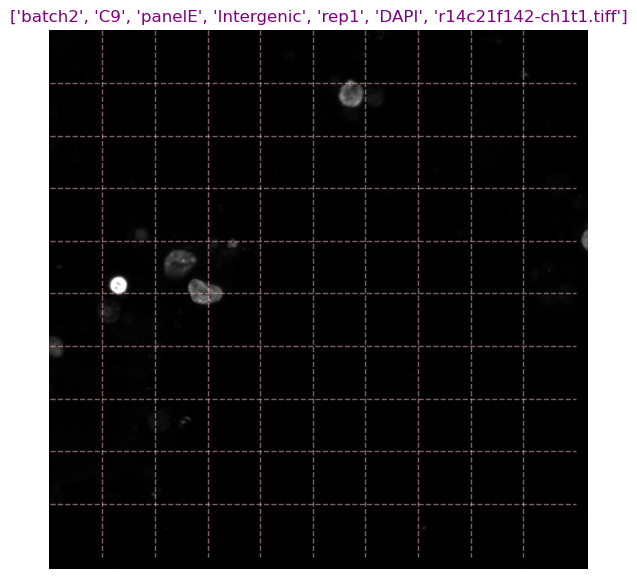

--------------------------------
1


Cropping image to fit


Brenner: 335.906
Img shape: (1024, 1024)


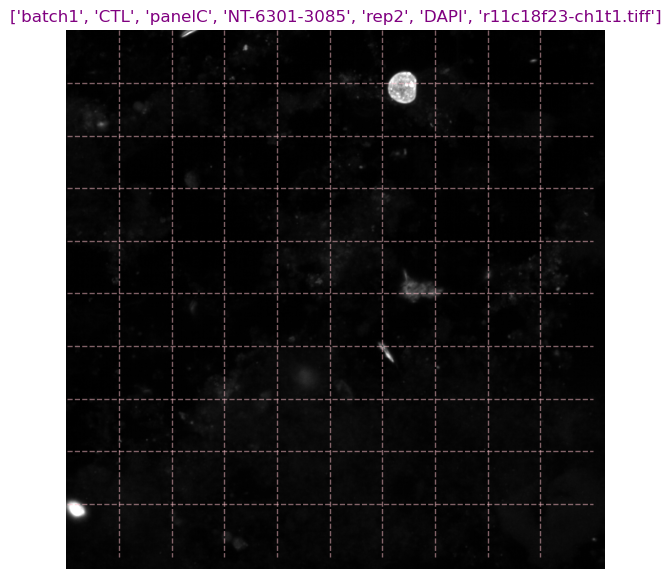

--------------------------------
2


Cropping image to fit


Brenner: 172.399
Img shape: (1024, 1024)


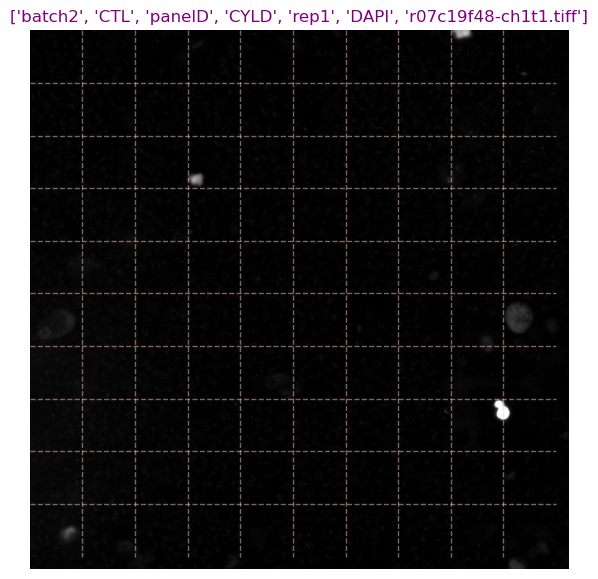

Cropping image to fit


--------------------------------
3
Brenner: 320.989
Img shape: (1024, 1024)


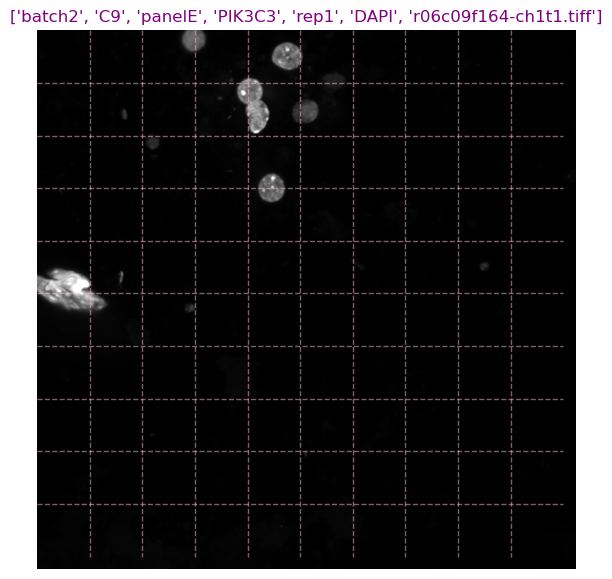

--------------------------------
4


Cropping image to fit


Brenner: 240.129
Img shape: (1024, 1024)


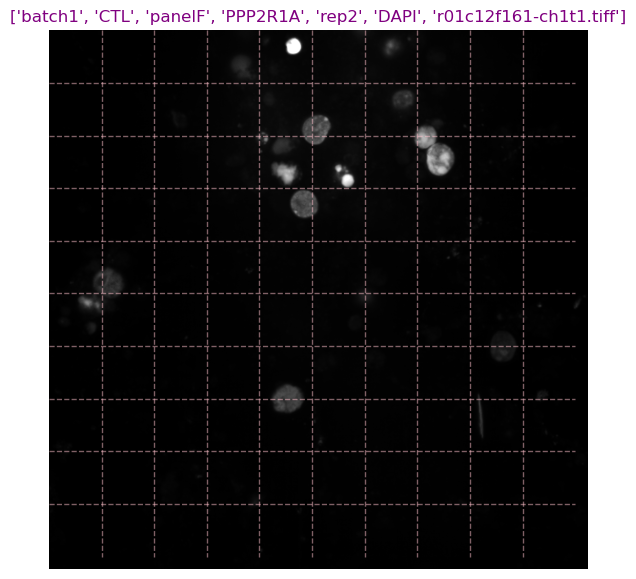

--------------------------------
5


Cropping image to fit


Brenner: 304.874
Img shape: (1024, 1024)


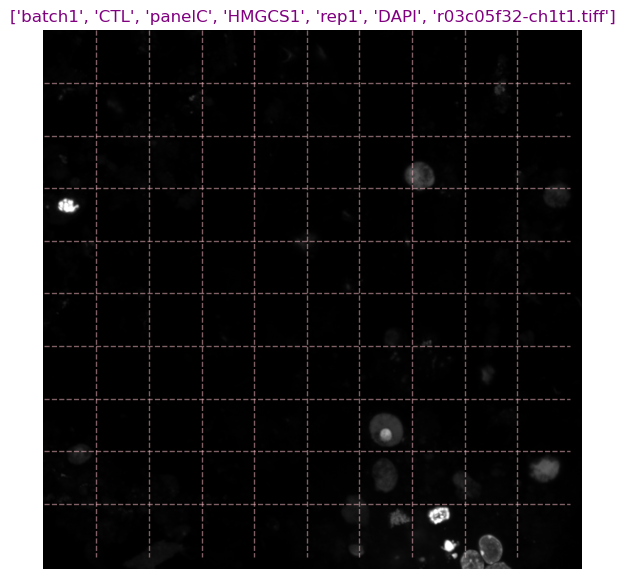

--------------------------------
6


Cropping image to fit


Brenner: 209.274
Img shape: (1024, 1024)


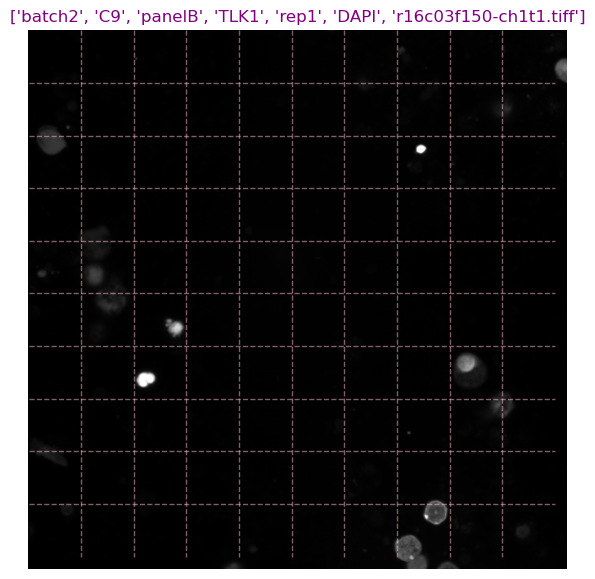

--------------------------------
7


Cropping image to fit


Brenner: 249.083
Img shape: (1024, 1024)


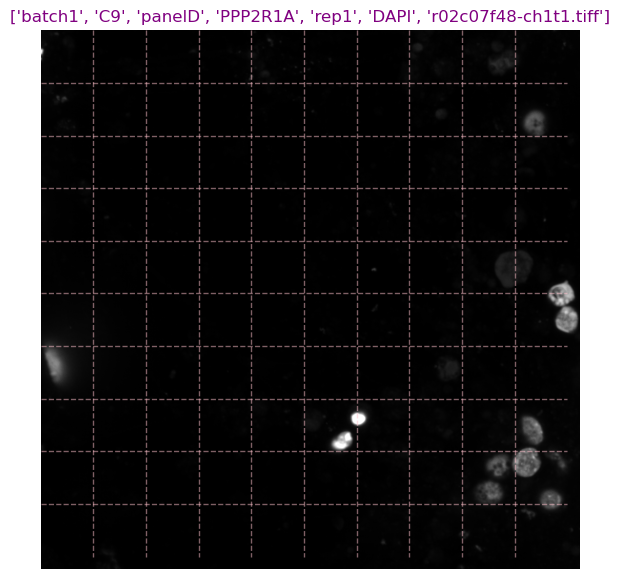

--------------------------------
8


Cropping image to fit


Brenner: 331.265
Img shape: (1024, 1024)


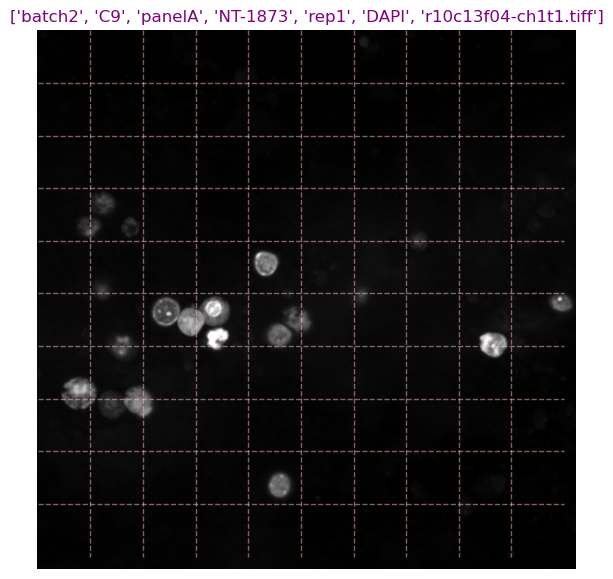

Cropping image to fit


--------------------------------
9
Brenner: 188.073
Img shape: (1024, 1024)


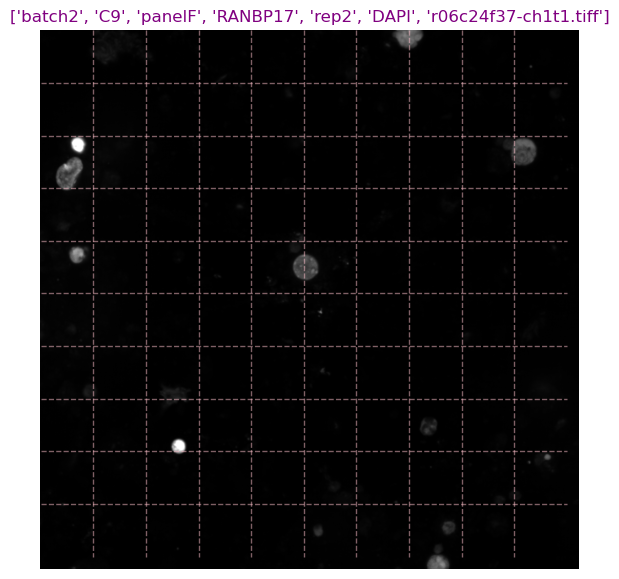

--------------------------------
10


Cropping image to fit


Brenner: 275.758
Img shape: (1024, 1024)


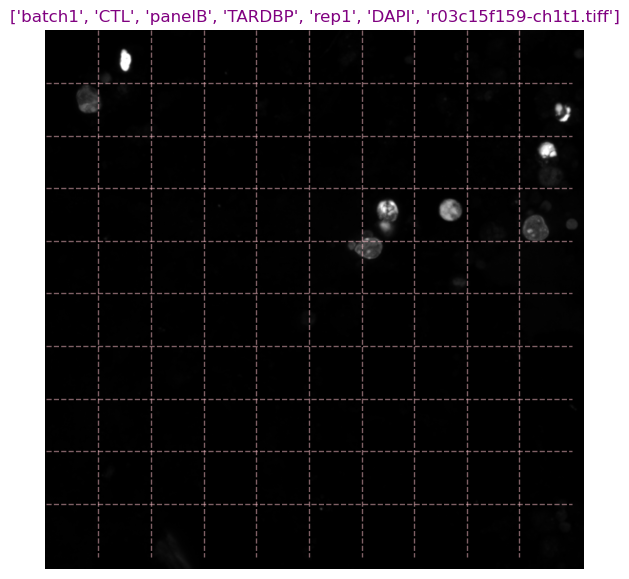

--------------------------------
11


Cropping image to fit


Brenner: 347.896
Img shape: (1024, 1024)


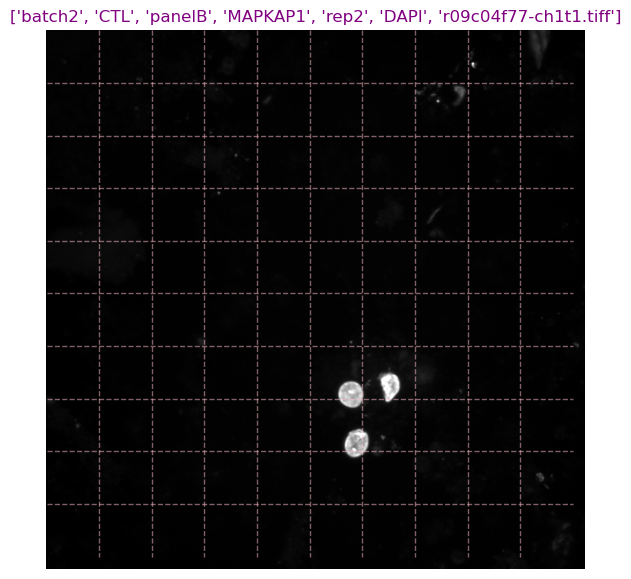

Cropping image to fit


--------------------------------
12
Brenner: 102.298
Img shape: (1024, 1024)


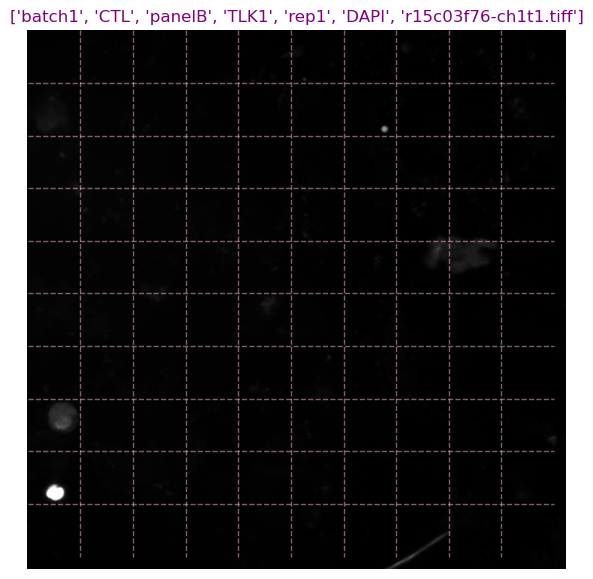

--------------------------------
13


Cropping image to fit


Brenner: 366.551
Img shape: (1024, 1024)


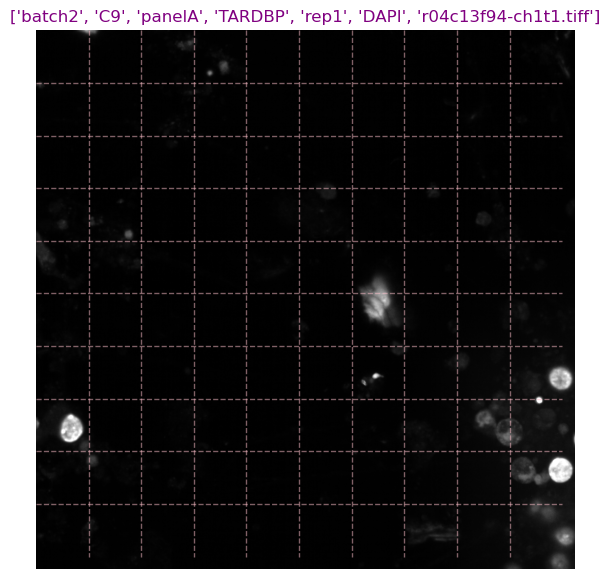

Cropping image to fit


--------------------------------
14
Brenner: 364.63
Img shape: (1024, 1024)


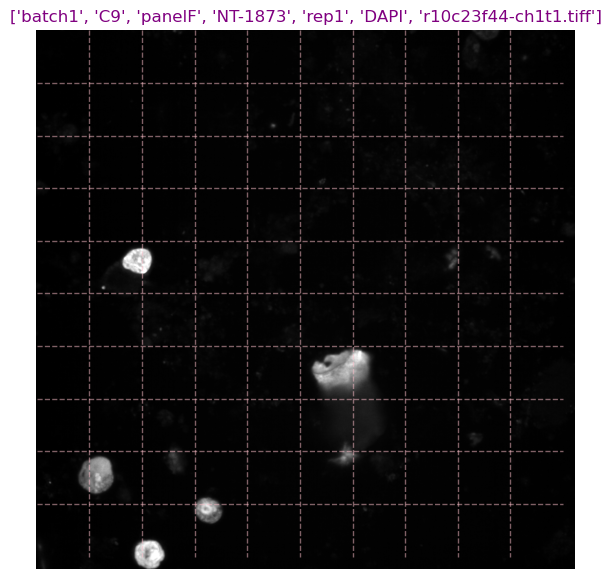

Cropping image to fit


--------------------------------
15
Brenner: 297.481
Img shape: (1024, 1024)


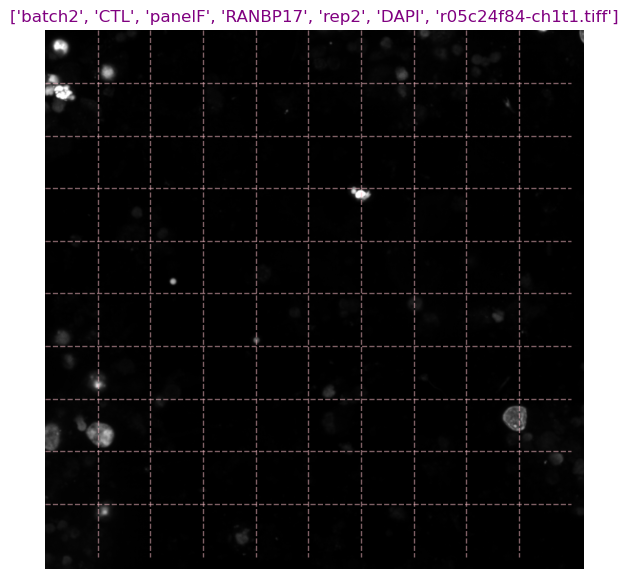

--------------------------------
16


Cropping image to fit


Brenner: 262.336
Img shape: (1024, 1024)


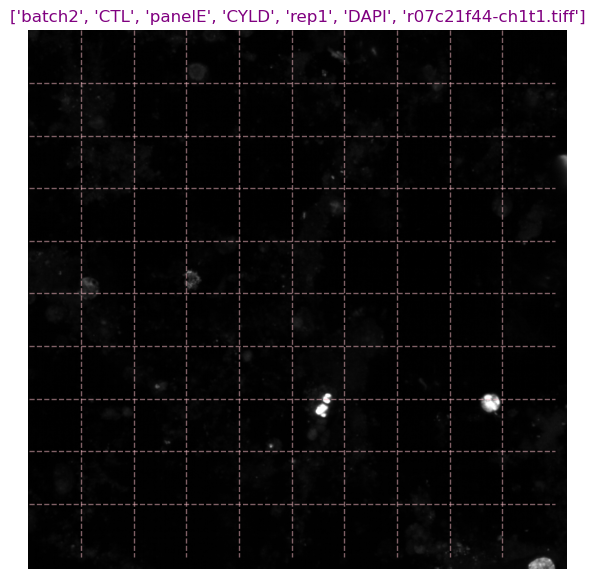

Cropping image to fit


--------------------------------
17
Brenner: 294.868
Img shape: (1024, 1024)


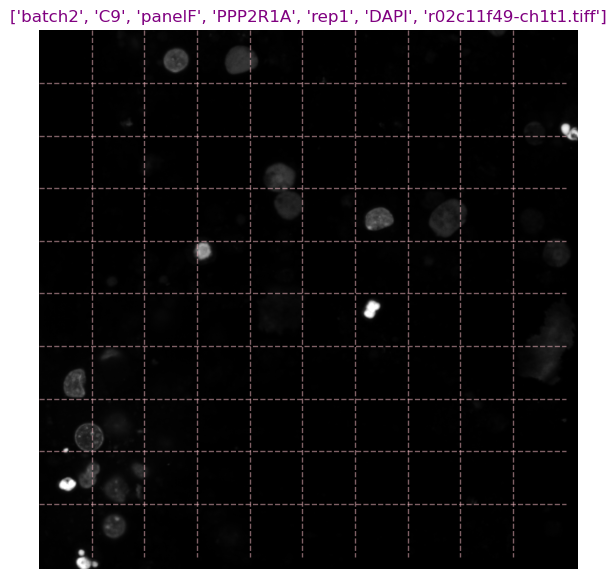

--------------------------------
18


Cropping image to fit


Brenner: 160.391
Img shape: (1024, 1024)


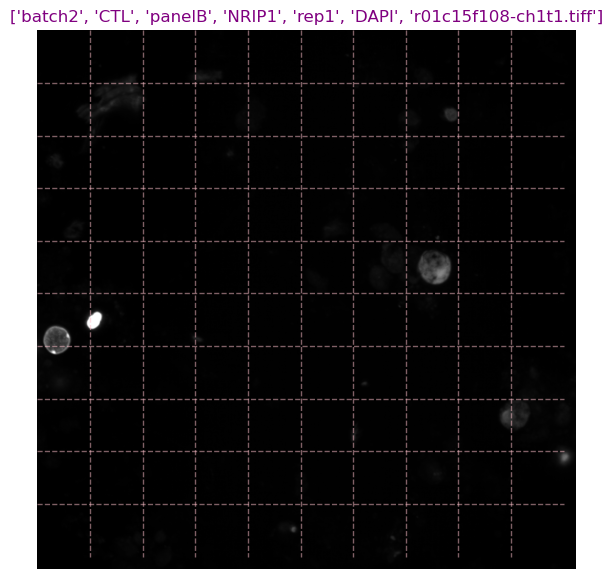

--------------------------------
19


Cropping image to fit


Brenner: 262.947
Img shape: (1024, 1024)


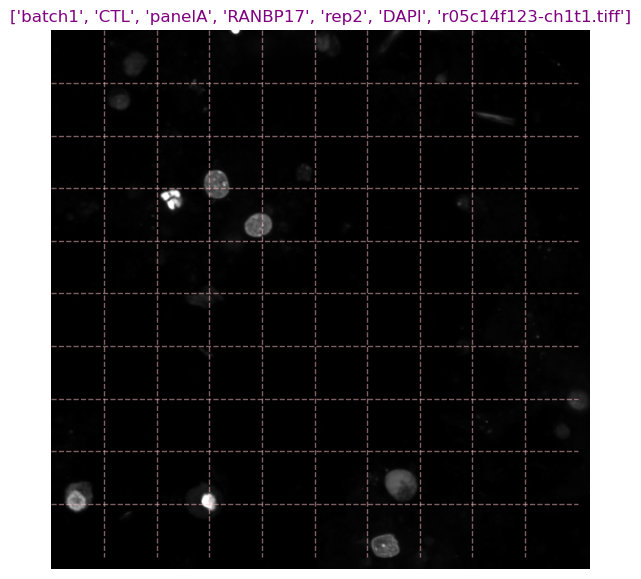

--------------------------------
20
Stopping at 20. There are 7680 images in total


In [39]:
#################### SAFE ZONE TO CHANGE ###############


per_min = 40
per_max = 50
batch=None
rep=None
cell_line=None

max_samples = 20

###################### END OF SAFE ZONE ###################


df_marker = df.loc[df['Marker'] == marker]
marker_max_value = df_marker[metric_name].max()
# if cell_line is not None:
#     df_marker=df_marker[(df_marker.Batch_Rep==f'{batch}/{rep}') & (df_marker.CellLine==cell_line)]
# else:
#     df_marker=df_marker[(df_marker.Batch_Rep==f'{batch}/{rep}')]

percentiles = df_marker[metric_name].describe(percentiles=percentiles_to_describe)

print(f'Showing images between %{per_min} - {per_max}')
threshold = percentiles[f'{per_min}%']
threshold_second = percentiles[f'{per_max}%']

c = (df_marker[metric_name]>=threshold) & (df_marker[metric_name]<=threshold_second) 

# threshold
df_marker_filtered = df_marker[c]
# shuffle
df_marker_filtered = df_marker_filtered.sample(frac=1, random_state=1)
# df_marker_filtered.index = range(len(df_marker_filtered))

print(f"Number of {marker} images in threshold {threshold} ({per_min}%) (and {threshold_second} ({per_max}%)): {len(df_marker_filtered)}")
print("\n")
print(df_marker_filtered['CellLine'].value_counts().to_string())
print("\n")
print(df_marker_filtered['Condition'].value_counts().to_string())
print("\n")
show_images(df_marker_filtered, max_samples=max_samples, lower_bound=lower_bound, upper_bound=upper_bound)

In [36]:
df.groupby(['Marker','Condition','CellLine','Batch_Rep']).count()

Path  RootFolder  Rep  Batch  \
Marker  Condition CellLine Batch_Rep                                   
ATF6    CYLD      C9       batch1/rep1   100         100  100    100   
                           batch1/rep2   100         100  100    100   
                           batch2/rep1   100         100  100    100   
                           batch2/rep2   100         100  100    100   
                  CTL      batch1/rep1   100         100  100    100   
...                                      ...         ...  ...    ...   
pTDP-43 Untreated C9       batch2/rep2   100         100  100    100   
                  CTL      batch1/rep1   100         100  100    100   
                           batch1/rep2   100         100  100    100   
                           batch2/rep1   100         100  100    100   
                           batch2/rep2   100         100  100    100   

                                        Target_Sharpness_Brenner  
Marker  Condition CellLine Batch_Rep                              
ATF6    CYLD      C9       batch1/rep1                       100  
                           batch1/rep2                       100  
                           batch2/rep1                       100  
                           batch2/rep2                       100  
                  CTL      batch1/rep1                       100  
...                                                          ...  
pTDP-43 Untreated C9       batch2/rep2                       100  
                  CTL      batch1/rep1                       100  
                           batch1/rep2                       100  
                           batch2/rep1                       100  
                           batch2/rep2                       100  

[2432 rows x 5 columns]

2. Setting Brenners in the csv

In [37]:
mappings_filepath

'/home/projects/hornsteinlab/giliwo/NOVA/manuscript/markers_focus_boundries/markers_focus_boundries_AAT_NOVA.csv'

In [38]:
# IN PRECENTAGES
thresholds = {
    'DAPI': (0, 100),
    'Cas3': (0, 100),
    'FK-2': (0, 100),
    'SMI32': (0, 100),
    'pDRP1': (0, 100),
    'TOMM20': (0, 100),
    'pCaMKIIa': (0, 100),
    'pTDP-43': (0, 100),
    'TDP-43': (0, 100),
    'ATF6': (0, 100),
    'pAMPK': (0, 100),
    'HDGFL2': (0, 100),
    'pS6': (0, 100),
    'PAR': (0, 100),
    'UNC13A': (0, 100),
    'Calreticulin': (0, 100),
    'LC3-II': (0, 100),
    'p62': (0, 100),
    'CathepsinD': (0, 100)
 }

mappings = update_all_mappings(mappings, thresholds, df)
mappings.to_csv(mappings_filepath)
mappings

Lower_bound  Upper_bound
DAPI                58.02     19728.34
Cas3               160.58      8327.49
FK-2                67.97     11010.36
SMI32               47.09     64126.56
pDRP1              207.40      4055.00
TOMM20             211.10      5590.68
pCaMKIIa           169.36      3153.38
pTDP-43            114.40      7485.59
TDP-43             117.76      8235.15
ATF6               135.56      5579.29
pAMPK               61.84     10539.62
HDGFL2             148.08      6790.27
pS6                 94.01     37611.53
PAR                112.15      7086.02
UNC13A             132.44      9090.57
Calreticulin       127.38      7975.72
LC3-II             282.30      8405.24
p62                464.49      5674.53
CathepsinD         368.52      4432.74